In [ ]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as v2
import torch

class Activities(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_id = self.annotations.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, f"{img_id}.jpg")
        image = Image.open(img_path).convert("RGB")
        
        target = self.annotations.iloc[idx, 1]  

        if self.transform:
            image = self.transform(image)

        return image, target

transform = v2.Compose([
    v2.Resize((256, 256)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.4674, 0.4498, 0.4123], [0.2686, 0.2641, 0.2690])
])

dataset = Activities(
    csv_file="./human_poses_data/train_answers.csv",
    img_dir="./human_poses_data/img_train/",
    transform=transform
)

In [ ]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

def compute_mean_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for images, _ in dataloader:
        channels_sum += torch.mean(images, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(images**2, dim=[0, 2, 3])
        num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2)**0.5
    return mean, std

mean, std = compute_mean_std(dataloader)
print("Mean:", mean)
print("Std:", std)

Mean: tensor([0.4674, 0.4498, 0.4123])
Std: tensor([0.2686, 0.2641, 0.2690])


In [8]:
df = pd.read_csv('./human_poses_data/activity_categories.csv')
categories = df.iloc[:, 1].values 

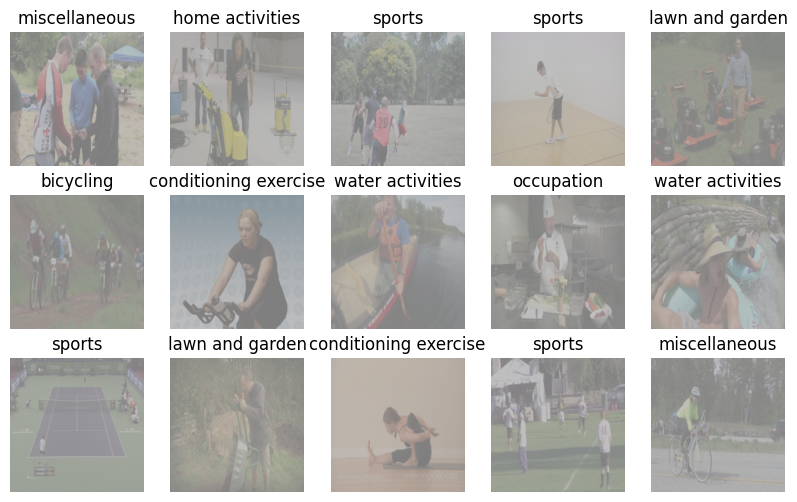

In [17]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,6))
    
for i in range(15):
    image, label = dataset[i]
    plt.subplot(3, 5, i + 1)
    plt.axis('off')
    plt.imshow(torch.clamp(dataset[i][0].permute(1, 2, 0) * 0.25 + 0.5, 0, 1))
    plt.title(categories[label])
    
plt.show()